In [1]:
from network_evaluation_tools import gene_conversion_tools as gct
import pandas as pd
import itertools
import numpy as np

In [2]:
wd = '/cellar/users/snwright/Data/Network_Analysis/'

# Version 2.0

## Load BioGRID Raw Data
**Source (MITAB): https://downloads.thebiogrid.org/File/BioGRID/Release-Archive/BIOGRID-4.4.203/BIOGRID-ORGANISM-4.4.203.tab3.zip**  
Downloaded: Nov 16, 2021   
Last Updated: October. 25th, 2021  
Notes for download: There is a new version of BioGRID released on the first of every month. Download the organism specific files to extract only human interactions from the database.  
Notes for processing: This is the file for human protein interactions, however, not all interactions may be human-human interactions. These need to be filtered. There is a column for "Score" filtering, but it seems that most of these values are missing so they will be ignored for processing BioGRID

In [3]:
input_raw_v2 = pd.read_csv(wd+'Network_Data_Raw/BIOGRID/BIOGRID-ORGANISM-Homo_sapiens-4.4.203.tab3.txt',sep='\t', low_memory=False)
print('Raw edge count in BioGRID:', len(input_raw_v2))
symbol_cols = {'Official Symbol Interactor A':'symbol_n1', 'Official Symbol Interactor B':'symbol_n2'}
input_raw_v2.rename(columns=symbol_cols, inplace=True)

Raw edge count in BioGRID: 961326


In [4]:
# Show not all interactions in BioGRID are physical PPI, though the overwhelming majority are
phys = input_raw_v2['Experimental System Type'].value_counts()
print(phys)
print("\nPercent physical:", round(phys["physical"]/sum(phys), 5))

physical    949337
genetic      11989
Name: Experimental System Type, dtype: int64

Percent physical: 0.98753


In [5]:
# Not all interactions are from Human
spec = input_raw_v2['Organism ID Interactor A'].value_counts().head()
print(spec)
print("\nPercent human:", round(spec[9606]/sum(spec), 5))

9606       909748
2697049     20096
10090       19506
559292       2421
11676        1836
Name: Organism ID Interactor A, dtype: int64

Percent human: 0.95401


In [6]:
# Not all interactions are from Human
spec = input_raw_v2['Organism ID Interactor B'].value_counts().head()
print(spec)
print("\nPercent human:", round(spec[9606]/sum(spec), 5))

9606      951674
10090       4813
559292      1139
10116       1003
284812       586
Name: Organism ID Interactor B, dtype: int64

Percent human: 0.99214


## Filter to human

In [7]:
input_human_v2 = input_raw_v2[(input_raw_v2['Organism ID Interactor A']==9606) & (input_raw_v2['Organism ID Interactor B']==9606)]
print('Human-Human only interactions in BioGRID 4.4.203:', len(input_human_v2))

Human-Human only interactions in BioGRID 4.4.203: 900096


In [8]:
# Any missing symbol names in column A?
input_human_v2['symbol_n1'][input_human_v2['symbol_n1']=='-']

Series([], Name: symbol_n1, dtype: object)

In [9]:
# Any missing symbol names in column B?
input_human_v2['symbol_n2'][input_human_v2['symbol_n2']=='-']

Series([], Name: symbol_n2, dtype: object)

In [10]:
# Convert table of interactions to edgelist (no scores given)
# Also no gene symbol conversion necessary because network is given in symbol format already
edgelist_v2 = input_human_v2[['symbol_n1', 'symbol_n2']].values.tolist()
print('Edges in BioGRID:', len(edgelist_v2))

Edges in BioGRID: 900096


In [11]:
# Sort each edge representation for filtering
edgelist_sorted_v2 = pd.DataFrame([sorted(edge) for edge in edgelist_v2], columns=["symbol_n1", "symbol_n2"])

## Query gene symbols

In [12]:
genes_v2 = (list(set(edgelist_sorted_v2["symbol_n1"]).union(set(edgelist_sorted_v2["symbol_n2"]))))
query_string_v2, valid_genes_v2, invalid_genes_v2 = gct.query_constructor(genes_v2)

19754 Valid Query Genes
1 Invalid Query Genes


In [13]:
mapped_v2, unmapped_v2 = gct.query_against_dataset("~/Data/Network_Analysis/Reference_Data/HGNC_download_2022.txt",
                              valid_genes_v2, return_as_dict=True)
mapped_v2 = pd.DataFrame.from_dict(mapped_v2).replace("NaN", np.nan)

In [14]:
match_table_trim_v2, query_to_symbol_v2, query_to_entrez_v2 = gct.construct_query_map_table(mapped_v2, valid_genes_v2)

Number of genes with multiple matches: 13
Number of unmatched genes: 225
Number of fully matched genes: 19421
Number of partially matched genes: 333


In [15]:
edgelist_updated_v2 = gct.convert_edgelist(edgelist_sorted_v2, query_to_symbol_v2)

In [16]:
# Filter edgelist for duplicate nodes and for self-edges
edgelist_filt_v2 = gct.filter_converted_edgelist(edgelist_updated_v2)

900096 input edges
7042 self-edges removed
1140 edges with un-mapped genes removed
224108 duplicate edges removed
Edge list filtered: 0.96 seconds
667806 Edges remaining


In [17]:
# Save genelist to file
outdir = wd+'Processed_Data/Network_SIFs_Symbol/'
gct.write_edgelist(edgelist_filt_v2, outdir+'BioGRID_Symbol_4_4_203.sif')

Edge list saved: 0.81 seconds


# Version 1.0 (original)

## Load BioGRID Raw Data
**Source (MITAB): http://thebiogrid.org/downloads/archives/Release%20Archive/BIOGRID-3.4.149/BIOGRID-ORGANISM-3.4.149.tab2.zip**  
Downloaded: June 15, 2017  
Last Updated: June 01, 2017  
Notes for download: There is a new verision of BioGRID released on the first of every month. Download the organism specific files to extract only human interactions from the database.  
Notes for processing: This is the file for human protein interactions, however, not all interactions may be human-human interactions. These need to be filtered. There is a column for "Score" filtering, but it seems that most of these values are missing so they will be ignored for processing BioGRID

In [19]:
input_raw = pd.read_csv(wd+'Network_Data_Raw/BIOGRID/BIOGRID-ORGANISM-Homo_sapiens-3.4.149.tab2.txt',sep='\t', low_memory=False)
print('Raw edge count in BioGRID_v1:', len(input_raw))
symbol_cols = {'Official Symbol Interactor A':'symbol_n1', 'Official Symbol Interactor B':'symbol_n2'}
input_raw.rename(columns=symbol_cols, inplace=True)

Raw edge count in BioGRID_v1: 394749


In [20]:
# Show not all interactions in BioGRID are physical PPI, though the overwhelming majority are
phys = input_raw['Experimental System Type'].value_counts()
print(phys)
print("\nPercent physical:", round(phys["physical"]/sum(phys), 5))

physical    392779
genetic       1970
Name: Experimental System Type, dtype: int64

Percent physical: 0.99501


In [21]:
# Not all interactions are from Human
spec = input_raw['Organism Interactor A'].value_counts().head()
print(spec)
print("\nPercent human:", round(spec[9606]/sum(spec), 5))

9606      372979
10090      17963
11676       1591
10116        570
559292       355
Name: Organism Interactor A, dtype: int64

Percent human: 0.94795


In [22]:
# Not all interactions are from Human
spec = input_raw['Organism Interactor B'].value_counts().head()
print(spec)
print("\nPercent human:", round(spec[9606]/sum(spec), 5))

9606      389334
10090       2543
559292      1045
10116        708
11676        318
Name: Organism Interactor B, dtype: int64

Percent human: 0.98829


 Since there are so few genetic interactions relative to physical interactions, we will not filter these edges. However, we will filter all interactions that are not labelled as human-human interactions

## Keep only human-human interactions

In [23]:
input_human = input_raw[(input_raw['Organism Interactor A']==9606) & (input_raw['Organism Interactor B']==9606)]
print('Human-Human only interactions in BioGRID 3.4.149:', len(input_human))

Human-Human only interactions in BioGRID 3.4.149: 367564


In [24]:
# Any missing symbol names in column A?
input_human['symbol_n1'][input_human['symbol_n1']=='-']

Series([], Name: symbol_n1, dtype: object)

In [25]:
# Any missing symbol names in column B?
input_human['symbol_n2'][input_human['symbol_n2']=='-']

Series([], Name: symbol_n2, dtype: object)

In [26]:
# Convert table of interactions to edgelist (no scores given)
# Also no gene symbol conversion necessary because network is given in symbol format already
edgelist = input_human[['symbol_n1', 'symbol_n2']].values.tolist()
print('Edges in BioGRID:', len(edgelist))

Edges in BioGRID: 367564


In [27]:
# Sort each edge representation for filtering
edgelist_sorted = pd.DataFrame([sorted(edge) for edge in edgelist], columns=["symbol_n1", "symbol_n2"])

## Query gene symbols

In [28]:
genes = (list(set(edgelist_sorted["symbol_n1"]).union(set(edgelist_sorted["symbol_n2"]))))
query_string, valid_genes, invalid_genes = gct.query_constructor(genes)

16718 Valid Query Genes
0 Invalid Query Genes


In [29]:
mapped, unmapped = gct.query_against_dataset("~/Data/Network_Analysis/Reference_Data/HGNC_download_2022.txt",
                              valid_genes, return_as_dict=True)
mapped = pd.DataFrame.from_dict(mapped).replace("NaN", np.nan)

In [30]:
match_table_trim, query_to_symbol, query_to_entrez = gct.construct_query_map_table(mapped, valid_genes)

Number of genes with multiple matches: 6
Number of unmatched genes: 96
Number of fully matched genes: 16528
Number of partially matched genes: 190


In [31]:
edgelist_updated = gct.convert_edgelist(edgelist_sorted, query_to_symbol)

In [32]:
# Filter edgelist for duplicate nodes and for self-edges
edgelist_filt = gct.filter_converted_edgelist(edgelist_updated)

367564 input edges
4601 self-edges removed
359 edges with un-mapped genes removed
104711 duplicate edges removed
Edge list filtered: 0.44 seconds
257893 Edges remaining


In [33]:
# Save genelist to file
outdir = wd+'Processed_Data/Network_SIFs_Symbol/'
gct.write_edgelist(edgelist_filt, outdir+'BioGRID_Symbol_3_4_149.sif')

Edge list saved: 0.44 seconds


# Changes

## Data Structure

**Columns renamed:**
* Organism Interactor A -> Organism ID Interactor A
* Organism Interactor B -> Organism ID Interactor B  
* Phenotypes -> Ontology Term Names

**Columns reworked:**
* Pubmed ID -> Publication Source
 * Format: `id(int)` -> `source:id(string)`

**New Columns**
* Ontology Term [IDs, Categories, Qualifier IDs, Qualifier Names, Types]
* Organism Name Interactor [A/B]
* [SWISS-PROT/TREMBL/REFSEQ] Accessions Interactor [A/B]


## Nodes/Edges

In [34]:

stats = pd.DataFrame({"v1":[len(input_raw), len(input_human), len(edgelist_filt), 99.5, 94.8, 98.8], 
                           "v2":[len(input_raw_v2), len(input_human_v2), len(edgelist_filt_v2),98.8, 95.4, 99.2]},
                           index=["input", "human_human", "filtered", "physical", "humanA", "humanB"])

In [35]:
v1_nodes = set(input_human["symbol_n1"].values).union(set(input_human["symbol_n2"].values))
v2_nodes = set(input_human_v2["symbol_n1"].values).union(set(input_human_v2["symbol_n2"].values))
new_nodes = v2_nodes.difference(v1_nodes)
print(len(new_nodes) == len(v2_nodes) - len(v1_nodes))
stats = stats.append(pd.DataFrame({"v1":len(v1_nodes), "v2":len(v2_nodes)}, index=["nodes"]))

True


<AxesSubplot:ylabel='Number of nodes'>

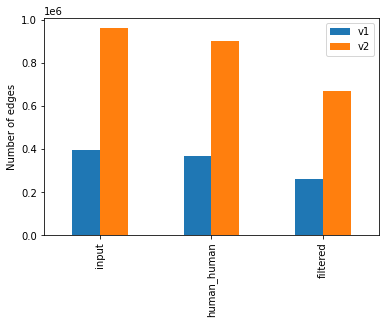

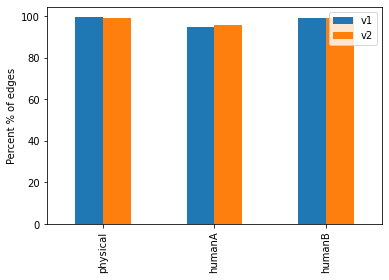

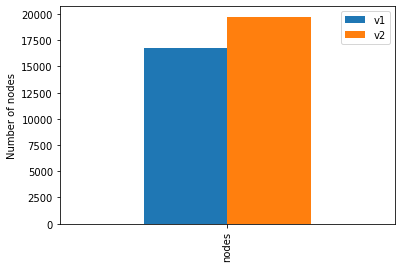

In [36]:
stats.loc[["input", "human_human", "filtered"]].plot.bar(ylabel="Number of edges")
stats.loc[["physical", "humanA", "humanB"]].plot.bar(ylabel="Percent % of edges")
stats.loc[["nodes"]].plot.bar(ylabel="Number of nodes")

array(['-', '1.0', '0.952', ..., '0.995751891', '0.978833402',
       '0.996471144'], dtype=object)